In [28]:
# Importing Libraries
import pandas as pd
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading global stock price data for exxon mobil
global_stock_exxon = pd.read_csv('final_global_stock_price_for_exxon.csv',index_col='Date',parse_dates=True)
global_stock_exxon.sort_index(inplace = True)
global_stock_exxon_start_date = global_stock_exxon.index[0]
global_stock_exxon_end_date = global_stock_exxon.index[-1]

## COMMODITY DATA PREPARATION FOR TRAINING WITH STOCK PRICE VALUE

In [3]:
# Loading the Commodity by BRENT Data and retrieving the segment of use
commodity_data_brent = pd.read_csv('commodity_prices_BRENT_Final.csv',index_col='Date',parse_dates=True)
commodity_data_brent.sort_index(inplace = True)
commodity_data_brent.drop(commodity_data_brent.filter(regex="Unname"),axis=1, inplace=True)
commodity_data_brent_segment = commodity_data_brent[global_stock_exxon_start_date:global_stock_exxon_end_date]
commodity_data_brent_segment_start_date = commodity_data_brent_segment.index[0]
commodity_data_brent_segment_end_date = commodity_data_brent_segment.index[-1]
commodity_data_brent_segment.drop(columns = 'LAST',inplace = True)

In [4]:
# Loading the Commodity by NYMEX Data and retrieving the segment of use
commodity_data_nymex = pd.read_csv('commodity_prices_NYMEX_Final.csv',index_col='Date',parse_dates=True)
commodity_data_nymex.sort_index(inplace = True)
commodity_data_nymex.drop(commodity_data_nymex.filter(regex="Unname"),axis=1, inplace=True)
commodity_data_nymex_segment = commodity_data_nymex[global_stock_exxon_start_date:global_stock_exxon_end_date]
commodity_data_nymex_segment_start_date = commodity_data_nymex_segment.index[0]
commodity_data_nymex_segment_end_date = commodity_data_nymex_segment.index[-1]

In [5]:
# Using Rolling Mean to handle the NaN values present in the data
for j in range(6):
    for i in commodity_data_brent_segment.columns:
        commodity_data_brent_segment['{}_Avg'.format(i)] = commodity_data_brent_segment[i].rolling(500,min_periods = 1,center = True).mean()
        for j in commodity_data_brent_segment.index:
            if np.isnan(commodity_data_brent_segment[i][j]):
                commodity_data_brent_segment[i][j] = commodity_data_brent_segment['{}_Avg'.format(i)][j]
        commodity_data_brent_segment = commodity_data_brent_segment.drop(columns = ['{}_Avg'.format(i)])

In [6]:
# Using Rolling Mean to handle the NaN values present in the data
for j in range(6):
    for i in commodity_data_nymex_segment.columns:
        commodity_data_nymex_segment['{}_Avg'.format(i)] = commodity_data_nymex_segment[i].rolling(500,min_periods = 1,center = True).mean()
        for j in commodity_data_nymex_segment.index:
            if np.isnan(commodity_data_nymex_segment[i][j]):
                commodity_data_nymex_segment[i][j] = commodity_data_nymex_segment['{}_Avg'.format(i)][j]
        commodity_data_nymex_segment = commodity_data_nymex_segment.drop(columns = ['{}_Avg'.format(i)])

In [7]:
# Creating the segment of stock data such that both the data are in same timeframe 
stock_data_exxon_segment = global_stock_exxon[commodity_data_brent_segment_start_date:commodity_data_brent_segment_end_date]

In [8]:
# Creating final data that is used for training the model which gives the impact of Commodity Data on Stock Price Value
combined_column_list = []
for i in commodity_data_brent_segment.columns:
    combined_column_list.append('brent_{}'.format(i))
for i in commodity_data_nymex_segment.columns:
    combined_column_list.append('nymex_{}'.format(i))
for i in stock_data_exxon_segment.columns:
    combined_column_list.append(i)

In [9]:
# Creating Joint data of Commodity and Stock Price Value
commodity_vs_stock_exxon_data = pd.DataFrame()
for i in combined_column_list:
    if i == 'Value':
        commodity_vs_stock_exxon_data[i] = stock_data_exxon_segment['Value']        
    elif i == 'Data Present':
        commodity_vs_stock_exxon_data[i] = stock_data_exxon_segment['Data Present']
    elif i.split('_')[0] == 'brent':
        col = i.split('_')[1]
        commodity_vs_stock_exxon_data[i] = commodity_data_brent_segment[col]
    else:
        col = i.split('_')[1]
        commodity_vs_stock_exxon_data[i] = commodity_data_nymex_segment[col]

In [10]:
# Function for Spliting the data into Training-Validation-Testing Data with split ratio as 80-10-10

def train_valid_test_split(dataset):
    tr_size=int((dataset.shape[0])*0.8)
    va_size=int((dataset.shape[0])*0.9)
    train = dataset[:tr_size]
    validation = dataset[tr_size:va_size]
    test = dataset[va_size:]
    return train,validation,test

In [11]:
# Spliting the data into Training-Validation-Testing Data with split ratio as 80-10-10
train, validation, test = train_valid_test_split(commodity_vs_stock_exxon_data)

In [12]:
# Getting the trainable features and label from the actual data

# Training Set
train_X = train.drop(columns=['Value'])
train_y = train['Value']

# Validation Set
validation_X = validation.drop(columns=['Value'])
validation_y = validation['Value']

# Testing Set
test_X = test.drop(columns=['Value'])
test_y = test['Value']

## Training LinearRegression Model to get linear impact of Commodity Data on Stock Price of Exxon

In [13]:
# Importing LinearRegression Model from sklearn
from sklearn.linear_model import LinearRegression

In [14]:
# Creating and Fitting the linear model on Training Set of the data
linear_model = LinearRegression()
linear_model.fit(train_X,train_y)

LinearRegression()

In [15]:
# Predicting the stock price value for exxon using linear model
pred_train_y = linear_model.predict(train_X)
pred_valid_y = linear_model.predict(validation_X)
pred_test_y = linear_model.predict(test_X)

In [16]:
# Using Root Mean Squared Error Metrics for Model Evaluation
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(train_y,pred_train_y))
rmse_valid = np.sqrt(mean_squared_error(validation_y,pred_valid_y))
rmse_test = np.sqrt(mean_squared_error(test_y,pred_test_y))

rmse_train,rmse_valid,rmse_test

(6.849217382388239, 20.32747353354269, 23.6816156665315)

In [17]:
#Creating the target vs prediction dataframe for each set of data for linear model

train_result = pd.DataFrame()
train_result['target'] = train_y
train_result['predicted']=pred_train_y
train_result.to_csv('linear_model_train_result.csv')

validation_result = pd.DataFrame()
validation_result['target'] = validation_y
validation_result['predicted']=pred_valid_y
validation_result.to_csv('linear_model_validation_result.csv')

test_result = pd.DataFrame()
test_result['target'] = test_y
test_result['predicted']=pred_test_y
test_result.to_csv('linear_model_test_result.csv')

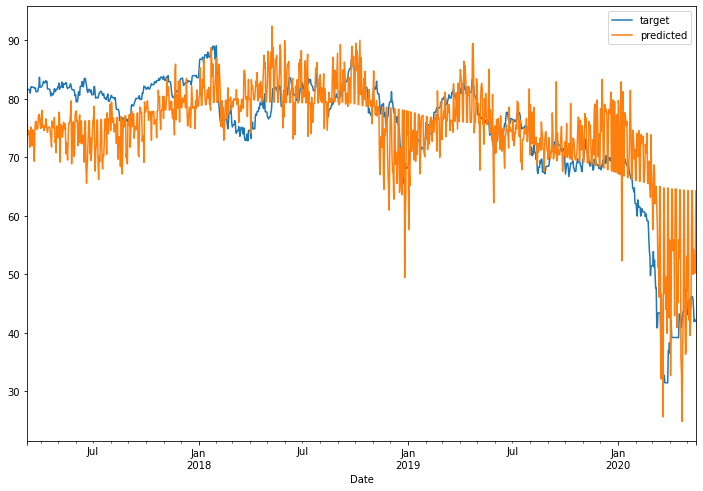

In [18]:
# Plotting the fit of prediction to the target of training data for linear model
train_result[['target','predicted']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Getting the feature importance of Commodity Data using Permutation_Importance by Sklearn for Linear Model

In [19]:
from sklearn.inspection import permutation_importance

In [20]:
# Knowing the importance of each feature of JODI Data for linear model

linear = permutation_importance(linear_model,train_X, train_y,n_repeats=30,random_state=43)
for i in linear.importances_mean.argsort()[::-1]:
    if linear.importances_mean[i] - 2 * linear.importances_std[i] > 0:
        print(f"{combined_column_list[i]:<8}"
              f"{linear.importances_mean[i]:.3f}"
              f" +/- {linear.importances_std[i]:.3f}")

brent_LOW30.575 +/- 1.045
nymex_HIGH23.615 +/- 0.772
brent_HIGH23.039 +/- 0.773
nymex_LOW19.518 +/- 0.597
brent_OPEN4.712 +/- 0.156
brent_SETTLE4.001 +/- 0.146
nymex_OPEN2.683 +/- 0.096
nymex_SETTLE1.522 +/- 0.049
nymex_PRICE IN USD1.489 +/- 0.054
nymex_CHANGE0.744 +/- 0.023
nymex_LAST0.132 +/- 0.008
brent_VOLUME0.090 +/- 0.007
nymex_PREVIOUS DAY OPEN INTEREST0.032 +/- 0.004
brent_PRICE IN USD0.032 +/- 0.004


## Training RandomForestRegressor Model to get non-linear impact of Commodity Data on Stock Price of Exxon

In [21]:
# Importing RandomForestRegressor Model from sklearn
from sklearn.ensemble import RandomForestRegressor

In [22]:
# Creating and Fitting the random forest model on Training Set of the data
rf_model = RandomForestRegressor()
rf_model.fit(train_X,train_y)

RandomForestRegressor()

In [23]:
# Predicting the stock price value for exxon using random forest model
pred_train_y_rf = rf_model.predict(train_X)
pred_valid_y_rf = rf_model.predict(validation_X)
pred_test_y_rf = rf_model.predict(test_X)

In [24]:
# Using Root Mean Squared Error Metrics for Model Evaluation

rmse_train_rf = np.sqrt(mean_squared_error(train_y,pred_train_y_rf))
rmse_valid_rf = np.sqrt(mean_squared_error(validation_y,pred_valid_y_rf))
rmse_test_rf = np.sqrt(mean_squared_error(test_y,pred_test_y_rf))

rmse_train_rf,rmse_valid_rf,rmse_test_rf

(1.5413947056157995, 16.91295430625122, 24.900015105668793)

In [25]:
#Creating the target vs prediction dataframe for each set of data for random forest model

train_result_rf = pd.DataFrame()
train_result_rf['target'] = train_y
train_result_rf['predicted']=pred_train_y_rf
train_result_rf.to_csv('random_forest_model_train_result.csv')

validation_result_rf = pd.DataFrame()
validation_result_rf['target'] = validation_y
validation_result_rf['predicted']=pred_valid_y_rf
validation_result_rf.to_csv('random_forest_model_validation_result.csv')

test_result_rf = pd.DataFrame()
test_result_rf['target'] = test_y
test_result_rf['predicted']=pred_test_y_rf
test_result_rf.to_csv('random_forest_model_test_result.csv')

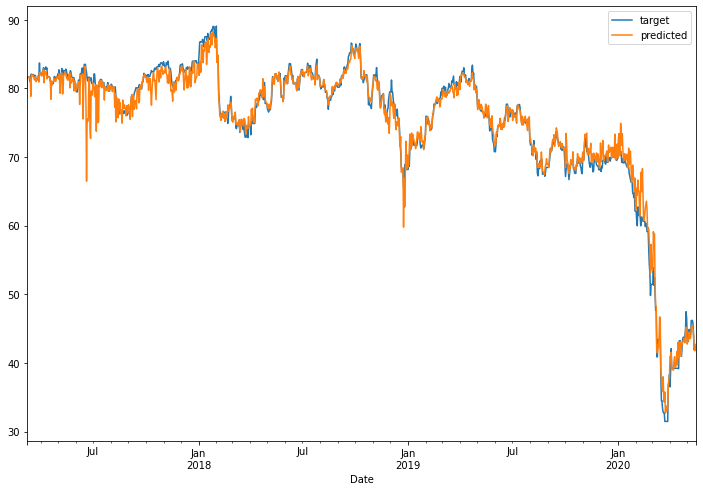

In [26]:
# Plotting the fit of prediction to the target of training data for random forest model
train_result_rf[['target','predicted']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Getting the feature importance of Commodity Data using Permutation_Importance by Sklearn for Random Forest Model

In [27]:
# Knowing the importance of each feature of Commodity Data for random forest model

rf = permutation_importance(rf_model,train_X, train_y,n_repeats=30,random_state=43)
for i in rf.importances_mean.argsort()[::-1]:
    if rf.importances_mean[i] - 2 * rf.importances_std[i] > 0:
        print(f"{combined_column_list[i]:<8}"
              f"{rf.importances_mean[i]:.3f}"
              f" +/- {rf.importances_std[i]:.3f}")

nymex_LOW0.657 +/- 0.025
nymex_PREVIOUS DAY OPEN INTEREST0.102 +/- 0.006
nymex_CHANGE0.098 +/- 0.007
brent_VOLUME0.072 +/- 0.005
brent_HIGH0.067 +/- 0.003
brent_CHANGE0.047 +/- 0.003
brent_PREVIOUS DAY OPEN INTEREST0.031 +/- 0.002
nymex_PRICE IN USD0.027 +/- 0.001
brent_PRICE IN USD0.026 +/- 0.001
nymex_LAST0.025 +/- 0.002
brent_LOW0.023 +/- 0.001
nymex_VOLUME0.022 +/- 0.002
brent_SETTLE0.020 +/- 0.001
nymex_OPEN0.015 +/- 0.001
brent_OPEN0.015 +/- 0.000
nymex_HIGH0.008 +/- 0.000
nymex_SETTLE0.006 +/- 0.000
Value   0.003 +/- 0.000
